In [1]:
import datetime
import json
import pandas as pd

# Define a dictionary to map sleep stage values to their corresponding labels
sleep_stage_labels = {
    1: "Awake (during sleep cycle)",
    2: "Sleep",
    3: "Out-of-bed",
    4: "Light sleep",
    5: "Deep sleep",
    6: "REM"
}

# Read sleep segment data from file
data = pd.read_json("..\Fit\All Data\derived_com.google.sleep.segment_com.google.an.json")
sleep_segments = data["Data Points"]

# Convert Epoch time to datetime objects and adjust dates
for segment in sleep_segments:
    start_time = datetime.datetime.fromtimestamp(int(segment["startTimeNanos"]) / 1e9)
    end_time = datetime.datetime.fromtimestamp(int(segment["endTimeNanos"]) / 1e9)
    if end_time.hour >= 16:
        segment_date = end_time.date()
    else:
        segment_date = start_time.date()
    segment["start_time"] = start_time
    segment["end_time"] = end_time
    segment["date"] = segment_date

# Calculate duration of each sleep segment in hours
for segment in sleep_segments:
    duration = (segment["end_time"] - segment["start_time"]).total_seconds() / 3600
    segment["duration"] = duration

# Group sleep segments by date and sum durations for each sleep stage
totals = {}
for segment in sleep_segments:
    date = segment["date"]
    sleep_stage = segment["fitValue"][0]["value"]["intVal"]
    if date not in totals:
        totals[date] = {label: 0 for label in sleep_stage_labels.values()}
    totals[date][sleep_stage_labels[sleep_stage]] += segment["duration"]

# Create a pandas DataFrame with date and hours slept for each sleep stage
df = pd.DataFrame.from_dict(totals, orient='index')
df.index.name = 'Date'
df.reset_index(inplace=True)

# Add a Total column to the DataFrame
df["Total"] = df.iloc[:, 1:].sum(axis=1)

# Calculate actual sleep time by subtracting "Awake" duration from "Total" duration
df["Actual Sleep Time"] = df["Total"] - df["Awake (during sleep cycle)"]

# Move "Actual Sleep Time" column to the left of "Total" column
df = df[["Date", "Awake (during sleep cycle)", "Sleep", "Out-of-bed", "Light sleep", "Deep sleep", "REM", "Actual Sleep Time", "Total"]]

# Sort the dataframe by date
df = df.sort_values(by="Date")

print(df)

           Date  Awake (during sleep cycle)  Sleep  Out-of-bed  Light sleep   
537  2019-07-28                    0.066667    0.0           0     0.958333  \
538  2019-07-29                    0.983333    0.0           0     3.691667   
539  2019-07-30                    0.783333    0.0           0     5.158333   
540  2019-07-31                    0.566667    0.0           0     3.675000   
541  2019-08-01                    0.008333    0.0           0     0.991667   
..          ...                         ...    ...         ...          ...   
532  2023-04-27                    0.716667    0.0           0     4.133333   
533  2023-04-28                    0.900000    0.0           0     5.366667   
534  2023-04-29                    1.133333    0.0           0     6.650000   
535  2023-04-30                    0.049999    0.0           0     0.916665   
536  2023-05-01                    0.533327    0.0           0     4.566658   

     Deep sleep       REM  Actual Sleep Time     To

In [2]:
df

,Date,Awake (during sleep cycle),Sleep,Out-of-bed,Light sleep,Deep sleep,REM,Actual Sleep Time,Total
537,2019-07-28,0.066667,0.0,0,0.958333,0.083333,0.000000,1.041667,1.108333
538,2019-07-29,0.983333,0.0,0,3.691667,1.416667,1.925000,7.033333,8.016667
539,2019-07-30,0.783333,0.0,0,5.158333,1.933333,2.058333,9.150000,9.933333
540,2019-07-31,0.566667,0.0,0,3.675000,0.466667,2.175000,6.316667,6.883333
541,2019-08-01,0.008333,0.0,0,0.991667,0.641667,0.158333,1.791667,1.800000
...,...,...,...,...,...,...,...,...,...
532,2023-04-27,0.716667,0.0,0,4.133333,0.000000,2.516667,6.650000,7.366666
533,2023-04-28,0.900000,0.0,0,5.366667,0.700000,1.966667,8.033334,8.933334
534,2023-04-29,1.133333,0.0,0,6.650000,0.416667,1.550000,8.616667,9.750000
535,2023-04-30,0.049999,0.0,0,0.916665,0.566666,0.033333,1.516664,1.566663


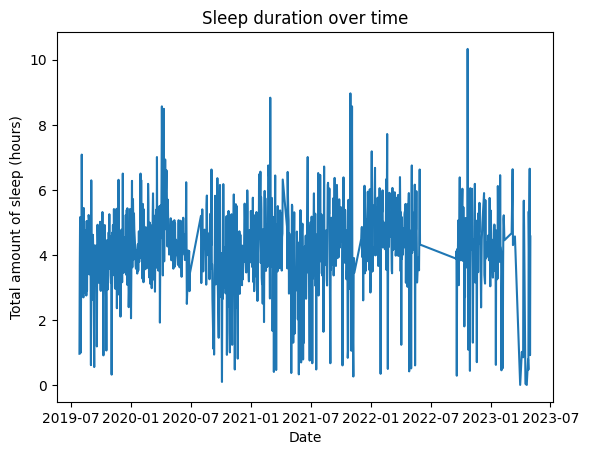

In [9]:
import matplotlib.pyplot as plt

# Plot the date vs the total amount of sleep
plt.plot(df['Date'], df['Total'])

# Add labels and title to the plot
plt.xlabel('Date')
plt.ylabel('Total amount of sleep (hours)')
plt.title('Sleep duration over time')

# Display the plot
plt.show()

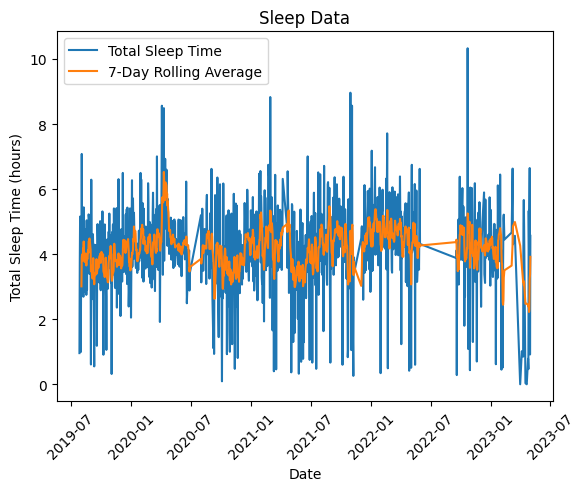

In [10]:
# Calculate the 7-day rolling average of total sleep time
df["Rolling Average"] = df["Total"].rolling(window=7).mean()

# Plot the date vs. total sleep time and rolling average
fig, ax = plt.subplots()
ax.plot(df["Date"], df["Total"], label="Total Sleep Time")
ax.plot(df["Date"], df["Rolling Average"], label="7-Day Rolling Average")
ax.set(xlabel="Date", ylabel="Total Sleep Time (hours)", title="Sleep Data")
ax.legend()
plt.xticks(rotation=45)
plt.show()

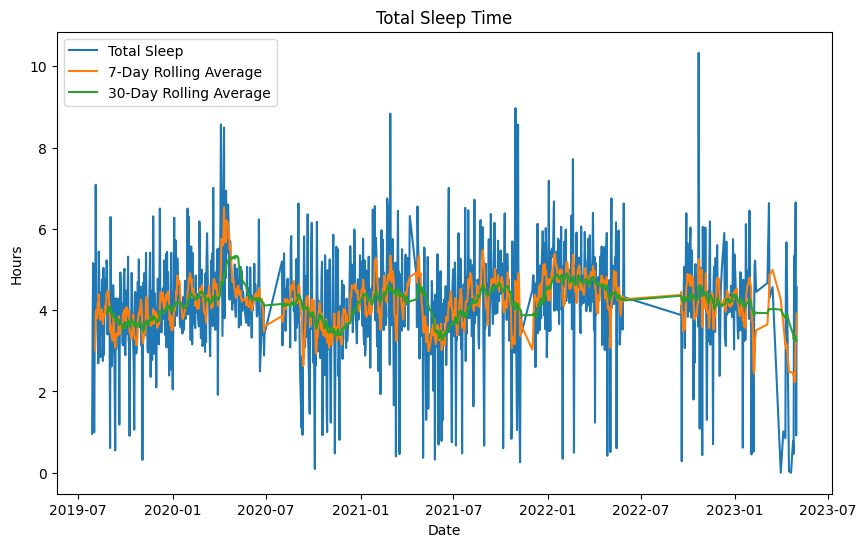

In [11]:
import matplotlib.pyplot as plt

# Set figure size
plt.figure(figsize=(10, 6))

# Plot total sleep time and rolling averages
plt.plot(df["Date"], df["Total"], label="Total Sleep")
plt.plot(df["Date"], df["Total"].rolling(window=7).mean(), label="7-Day Rolling Average")
plt.plot(df["Date"], df["Total"].rolling(window=30).mean(), label="30-Day Rolling Average")

# Set title and axis labels
plt.title("Total Sleep Time")
plt.xlabel("Date")
plt.ylabel("Hours")

# Add legend
plt.legend()

# Show plot
plt.show()

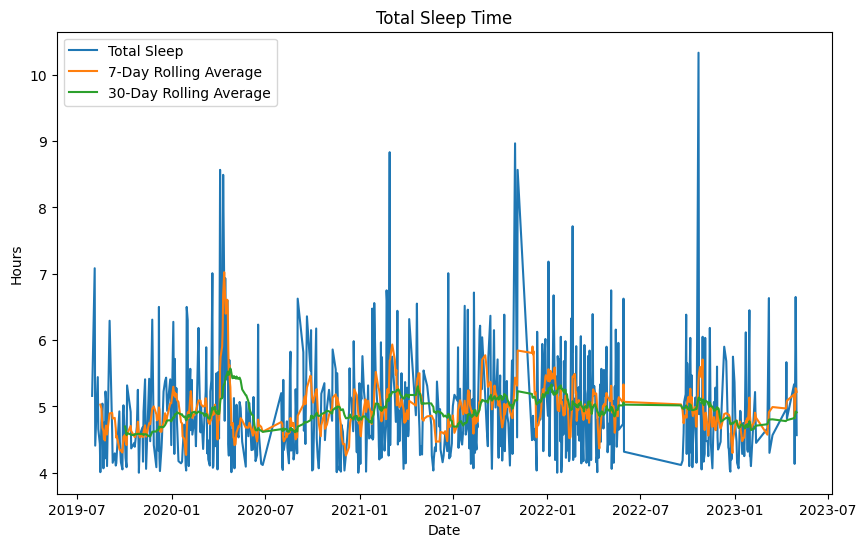

In [15]:
import matplotlib.pyplot as plt

# Filter data by excluding values with less than 4 hours of total sleep
df_filtered = df[df["Total"] >= 4]

# Set figure size
plt.figure(figsize=(10, 6))

# Plot total sleep time and rolling averages
plt.plot(df_filtered["Date"], df_filtered["Total"], label="Total Sleep")
plt.plot(df_filtered["Date"], df_filtered["Total"].rolling(window=7).mean(), label="7-Day Rolling Average")
plt.plot(df_filtered["Date"], df_filtered["Total"].rolling(window=30).mean(), label="30-Day Rolling Average")

# Set title and axis labels
plt.title("Total Sleep Time")
plt.xlabel("Date")
plt.ylabel("Hours")

# Add legend
plt.legend()

# Show plot
plt.show()

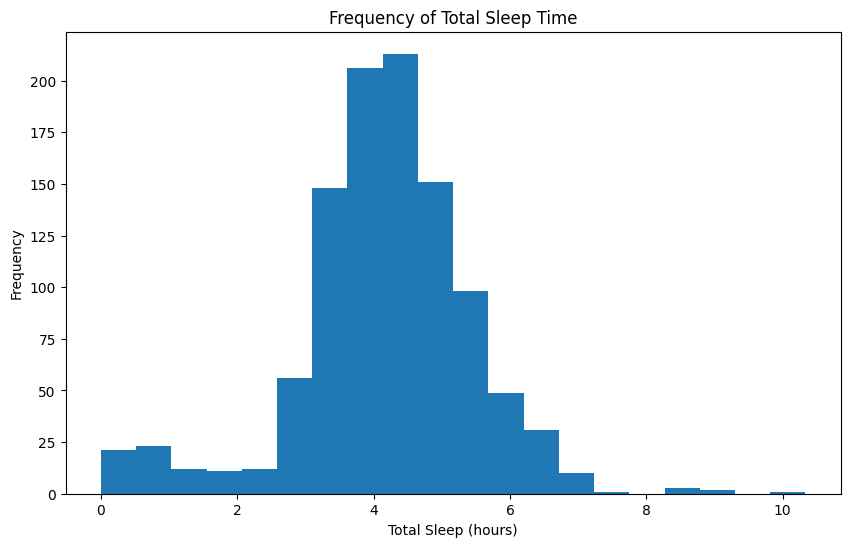

In [17]:
import matplotlib.pyplot as plt

# Filter data by excluding values with less than 4 hours of total sleep
df_filtered = df

# Set figure size
plt.figure(figsize=(10, 6))

# Create histogram of Total Sleep data
plt.hist(df_filtered["Total"], bins=20)

# Set title and axis labels
plt.title("Frequency of Total Sleep Time")
plt.xlabel("Total Sleep (hours)")
plt.ylabel("Frequency")

# Show plot
plt.show()

In [18]:
import matplotlib.pyplot as plt

# Set figure size
plt.figure(figsize=(10, 6))

# Define years to separate histograms by
years = [2018, 2019, 2020, 2021]

# Loop through each year and plot histogram
for year in years:
    # Filter data by year
    df_year = df[df["Date"].dt.year == year]
    
    # Plot histogram of total sleep time for this year
    plt.hist(df_year["Total"], bins=20, alpha=0.5, label=str(year))

# Set title and axis labels
plt.title("Frequency of Total Sleep Time by Year")
plt.xlabel("Total Sleep Time (Hours)")
plt.ylabel("Frequency")

# Add legend
plt.legend()

# Show plot
plt.show()

AttributeError: Can only use .dt accessor with datetimelike values

<Figure size 1000x600 with 0 Axes>

C:\Users\judea\AppData\Local\Temp\ipykernel_30804\363910710.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Year'] = pd.to_datetime(df_filtered['Date']).dt.year


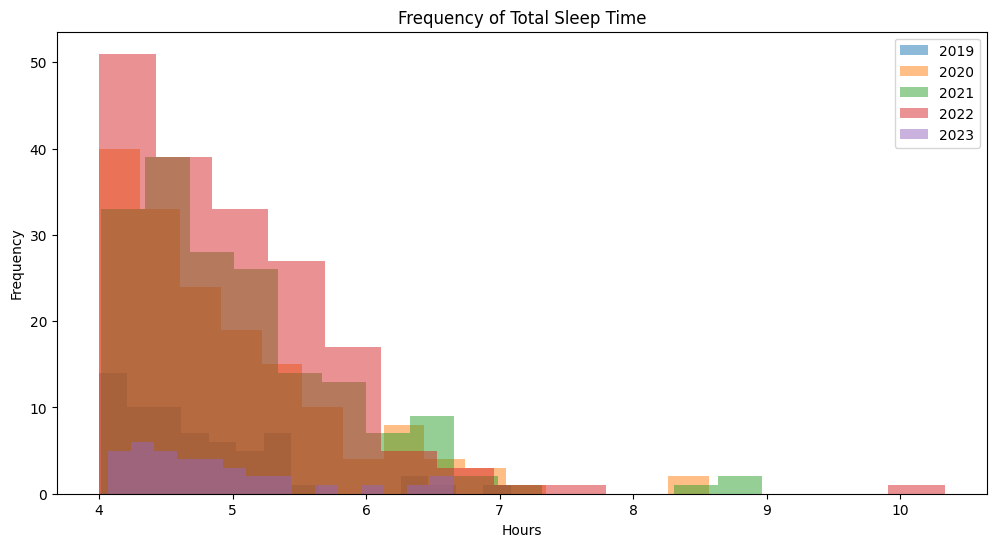

In [19]:
import matplotlib.pyplot as plt

# Filter data by excluding values with less than 4 hours of total sleep
df_filtered = df[df["Total"] >= 4]

# Extract year from date column
df_filtered['Year'] = pd.to_datetime(df_filtered['Date']).dt.year

# Set figure size
fig, ax = plt.subplots(figsize=(12, 6))

# Create separate histograms for each year
for year in df_filtered['Year'].unique():
    data = df_filtered[df_filtered['Year']==year]['Total']
    ax.hist(data, bins=15, alpha=0.5, label=str(year))

# Set title and axis labels
ax.set_title("Frequency of Total Sleep Time")
ax.set_xlabel("Hours")
ax.set_ylabel("Frequency")

# Add legend
ax.legend()

# Show plot
plt.show()

In [20]:
import matplotlib.pyplot as plt

# Set figure size
plt.figure(figsize=(10, 6))

# Create a histogram of total sleep time for each year
for year in range(df["Date"].min().year, df["Date"].max().year + 1):
    year_data = df[df["Date"].dt.year == year]
    plt.hist(year_data["Total"], bins=20, alpha=0.5, label=str(year))

# Set title and axis labels
plt.title("Distribution of Total Sleep Time by Year")
plt.xlabel("Hours")
plt.ylabel("Frequency")

# Add legend and adjust layout
plt.legend()
plt.tight_layout()

# Show plot
plt.show()

AttributeError: Can only use .dt accessor with datetimelike values

<Figure size 1000x600 with 0 Axes>

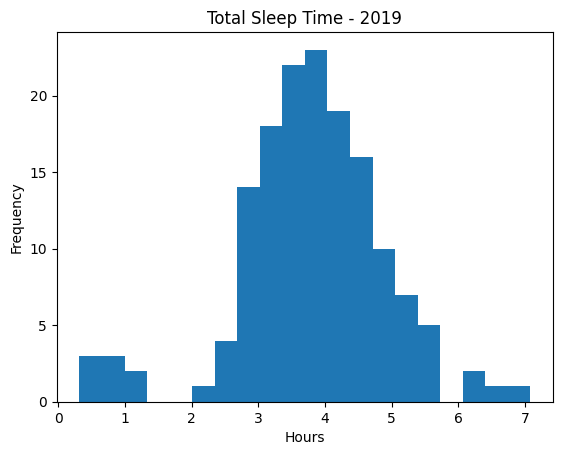

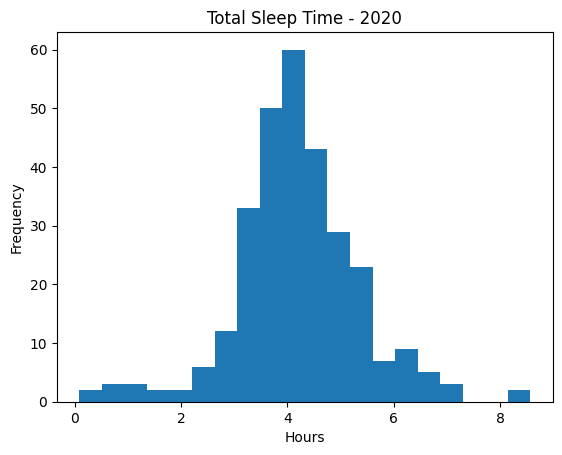

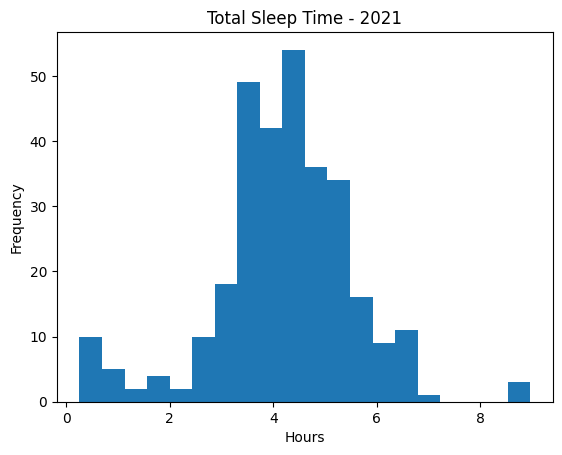

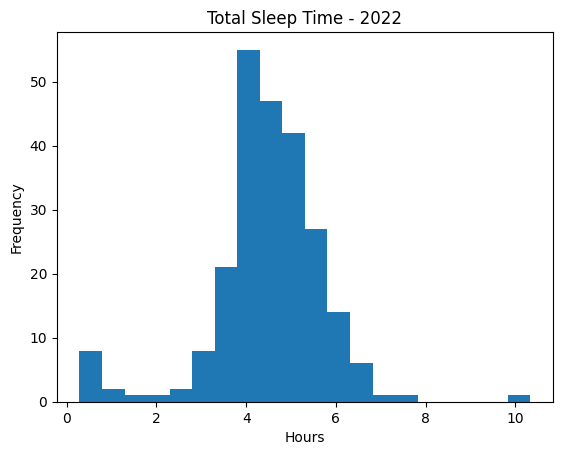

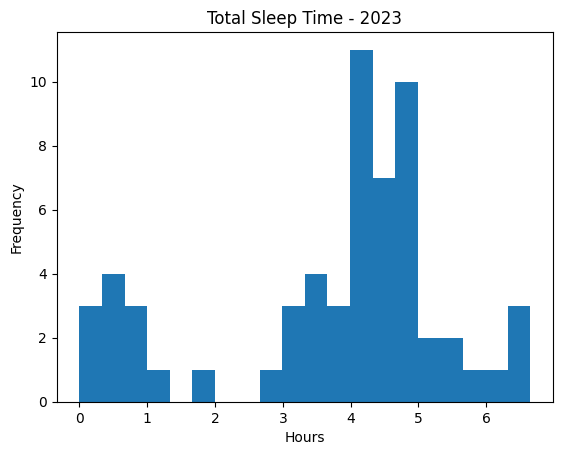

In [21]:
import matplotlib.pyplot as plt

# Convert "Date" column to datetime format
df["Date"] = pd.to_datetime(df["Date"])

# Group data by year
grouped = df.groupby(df["Date"].dt.year)

# Plot histograms for each year
for year, group in grouped:
    plt.figure()
    plt.hist(group["Total"], bins=20)
    plt.title(f"Total Sleep Time - {year}")
    plt.xlabel("Hours")
    plt.ylabel("Frequency")
    plt.show()